# EM for MLE and MAP

### The Target Distribution
Recall that in our model, we suppose that our data, $\mathbf{X}=\{\mathbf{x}_1, \ldots, \mathbf{x}_K\}$ is drawn from the mixture of $K$ number of Gaussian distributions. For each observation $\mathbf{x}_n$ we have a latent variable $\mathbf{z}_n$ that is a 1-of-$K$ binary vector with elements $z_{nk}$. We denote the set of latent variable by $\mathbf{Z}$. Recall that the distibution of $\mathbf{Z}$ given the mixing coefficients, $\pi$, is given by
\begin{align}
p(\mathbf{Z} | \pi) = \prod_{n=1}^N \prod_{k=1}^K \pi_k^{z_{nk}} 
\end{align}
Recall also that the likelihood of the data is given by,
\begin{align}
p(\mathbf{X} | \mathbf{Z}, \mu, \Sigma) =\prod_{n=1}^N \prod_{k=1}^K \mathcal{N}\left(\mathbf{x}_n| \mu_k, \Sigma_k\right)^{z_{nk}}
\end{align}
Finally, in our basic model, we choose a Dirichlet prior for $\pi$ 
\begin{align}
p(\pi) = \mathrm{Dir}(\pi | \alpha_0) = C(\alpha_0) \prod_{k=1}^K \pi_k^{\alpha_0 -1},
\end{align}
where $C(\alpha_0)$ is the normalizing constant for the Dirichlet distribution. We also choose a Normal-Inverse-Wishart prior for the mean and the covariance of the likelihood function
\begin{align}
p(\mu, \Sigma) = p(\mu | \Sigma) p(\Sigma) = \prod_{k=1}^K \mathcal{N}\left(\mu_k | \mathbf{m}_0, \mathbf{V}_0\right) IW(\Sigma_k|\mathbf{S}_0, \nu_0).
\end{align}
Thus, the joint distribution of all the random variable is given by
\begin{align}
p(\mathbf{X}, \mathbf{Z}, \pi, \mu, \Sigma) = p(\mathbf{X} | \mathbf{Z}, \mu, \Sigma) p(\mathbf{Z} | \pi) p(\pi) p(\mu | \Sigma) p(\Sigma)
\end{align}

### EM for MLE

#### E-step:
*Needs exposition*
\begin{align}
r_{nk} = \frac{\pi_k p\left(\mathbf{x}_n | \mu_k, \Sigma_k\right)}{\sum_{k'=1}^K \pi_{k'} p\left(\mathbf{x}_n | \mu_{k'}, \Sigma_{k'}\right)}
\end{align}

#### M-step:
*Needs exposition*
\begin{align}
\pi_k &= \frac{r_k}{N},\;\; r_k =\sum_{n=1}^N r_{nk}\\
\mu_k &=\frac{\sum_{n=1}^N r_{nk}\mathbf{x}_n}{r_k}\\
\Sigma_k &= \frac{\sum_{n=1}^N r_{nk} \mathbf{x}_n\mathbf{x}_n^\top}{r_k} - \mu_k\mu_k^\top
\end{align}

### EM for MAP

#### E-step:
*Needs exposition*
\begin{align}
r_{nk} = \frac{\pi_k p\left(\mathbf{x}_n | \mu_k, \Sigma_k\right)}{\sum_{k'=1}^K \pi_{k'} p\left(\mathbf{x}_n | \mu_{k'}, \Sigma_{k'}\right)}
\end{align}

#### M-step:
*Needs exposition*
\begin{align}
\pi_k &= \frac{r_k + \alpha_k - 1}{N + \sum_{k=1}^K \alpha_k - K},\;\; r_k =\sum_{n=1}^N r_{nk}\\
\hat{\mu}_k &=\frac{r_k \overline{\mathbf{x}}_k + \beta_0 \mathrm{m}_0}{r_k + \beta_0}\\
\overline{\mathbf{x}}_k&= \frac{\sum_{n=1}^N r_{nk} \mathbf{x}_n}{r_k}\\
\hat{\Sigma}_k &= \frac{\mathbf{S}_0 + \mathbf{S}_k + \frac{\beta_0r_k}{\beta_0 + r_k}(\overline{\mathbf{x}}_k - \mathbf{m}_0)(\overline{\mathbf{x}}_k - \mathbf{m}_0)^\top}{\nu_0 + r_k + D + 2}\\
\mathbf{S}_k &= \sum_{n=1}^N r_{nk} (\mathbf{x}_n - \overline{\mathbf{x}}_k)(\mathbf{x}_n - \overline{\mathbf{x}}_k)^\top
\end{align}


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from scipy.stats import multivariate_normal as MVN

import re
import numpy as np

/Users/isadoranun/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#------------------    Real Data    ----------------------#
t1 = time.time()
requests = pd.read_csv('../../311__Service_Requests.csv')
t2 = time.time()
print "Read in data in %.2f seconds." % (t2 - t1)

t1 = time.time()
closed_requests = requests[requests['CASE_STATUS'] == 'Closed']
t2 = time.time()
print "Filtered data in %.2f seconds." % (t2 - t1)


t1 = time.time()
for col in ['OPEN_DT', 'TARGET_DT', 'CLOSED_DT']:
    closed_requests[col] = pd.to_datetime(closed_requests[col], infer_datetime_format=True)
t2= time.time()
print "Dates processed in %.2f seconds." % (t2 - t1)

Read in data in 8.21 seconds.
Filtered data in 0.39 seconds.

/Users/isadoranun/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/isadoranun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Dates processed in 445.22 seconds.


In [121]:
closed_requests.head()

,CASE_ENQUIRY_ID,OPEN_DT,TARGET_DT,CLOSED_DT,OnTime_Status,CASE_STATUS,CLOSURE_REASON,CASE_TITLE,SUBJECT,REASON,...,precinct,land_usage,LOCATION_STREET_NAME,LOCATION_ZIPCODE,Property_Type,Property_ID,LATITUDE,LONGITUDE,Source,Geocoded_Location
0,101000958209,2013-11-01 09:27:19,2013-11-15 09:27:19,2013-11-27 10:15:45,OVERDUE,Closed,Case Closed Case Resolved,Sign Repair,Transportation - Traffic Division,Signs & Signals,...,308,NaN,INTERSECTION Devonshire St & Summer St,NaN,Intersection,4053,42.3537,-71.0580,Constituent Call,"(42.3537, -71.058)"
1,101000844074,2013-05-21 15:24:54,2013-05-23 15:24:53,2013-05-21 15:25:00,ONTIME,Closed,Case Closed Internal Case,Requests for Street Cleaning,Public Works Department,Street Cleaning,...,107,R1,166 Brooks St,2128,Address,22447,42.3795,-71.0357,Employee Generated,"(42.3795, -71.0357)"
2,101000487838,2012-10-03 11:56:43,2012-10-17 11:56:42,2013-03-06 10:29:08,OVERDUE,Closed,Case Closed Case Noted Sorry for the delayed r...,Street Light Outages,Public Works Department,Street Lights,...,204,CM,191-193 Bunker Hill St,2129,Address,162709,42.3790,-71.0616,Constituent Call,"(42.379, -71.0616)"
4,101001095899,2014-05-22 19:28:49,2014-05-27 08:30:00,2014-05-29 14:19:59,OVERDUE,Closed,Case Closed Case Resolved We have checked all ...,Traffic Signal Repair,Transportation - Traffic Division,Signs & Signals,...,501,NaN,INTERSECTION Arlington St & Herald St,NaN,Intersection,593,42.3475,-71.0686,Self Service,"(42.3475, -71.0686)"
5,101000364945,2011-12-16 11:32:08,NaT,2011-12-16 11:32:55,ONTIME,Closed,Case Closed Case Resolved,Schedule a Bulk Item Pickup,Public Works Department,Sanitation,...,806,E,115 Southampton St,2118,Address,129060,42.3317,-71.0695,Employee Generated,"(42.3317, -71.0695)"


In [126]:
begin_date='March 15, 2014 12:00PM'
end_date='March 19, 2014 12:00PM'
source = 'Constituent Call'

begin = pd.to_datetime(begin_date) 
end = pd.to_datetime(end_date)

in_range = closed_requests[closed_requests['OPEN_DT'] > begin]
in_range = in_range[in_range['OPEN_DT'] < end]
in_range = in_range[in_range['Source'] == source]

in_range.to_json("unclustered.json",orient="records")

In [120]:
########################################
########################################
#####       Makes real data        #####
########################################
########################################

def real_data(begin_date, end_date, source):
    begin = pd.to_datetime(begin_date) 
    end = pd.to_datetime(end_date)

    in_range = closed_requests[closed_requests['OPEN_DT'] > begin]
    in_range = in_range[in_range['OPEN_DT'] < end]
    in_range = in_range[in_range['Source'] == source]
    
    elapsed_time = in_range['CLOSED_DT'].values - in_range['OPEN_DT'].values
    elapsed_time = elapsed_time.astype('timedelta64[h]').astype('float64')

    data = np.hstack((elapsed_time.reshape((len(in_range), 1)), 
                      in_range['LATITUDE'].values.reshape((len(in_range), 1)), 
                      in_range['LONGITUDE'].values.reshape((len(in_range), 1))));
#                       in_range['SUBJECT'].values.reshape((len(in_range), 1)),
#                       in_range['REASON'].values.reshape((len(in_range), 1)),
#                       in_range['TYPE'].values.reshape((len(in_range), 1)),
#                       in_range['QUEUE'].values.reshape((len(in_range), 1)),
#                       in_range['Department'].values.reshape((len(in_range), 1))))

    return data

In [90]:
########################################
########################################
#####       Makes test data        #####
########################################
########################################

def test_data(N, D):
    n_samples = int(N/2.0) #number of points in each component
    mu1 = np.array([10] * D) #mean of component 1
    mu2 = np.array([6] * D) #mean of component 1

    # generate random sample, two components
    np.random.seed(0)

    # generate spherical data centered on mu1
    comp1 = np.random.randn(n_samples, D) + mu1
    
    # generate spherical data centered on mu2
    comp2 = np.random.randn(N - n_samples, D) + mu2

    # concatenate the two datasets into training set
    data = np.vstack([comp1, comp2])

    #plot the components
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(comp1[:, 0], comp1[:, 1], comp1[:, 2], c='r')
    ax.scatter(comp2[:, 0], comp2[:, 1], comp2[:, 2], c='b')

    plt.title('test data')
    plt.show()
    
    return data

In [91]:
########################################
########################################
###   K-means init for mu and Sigma  ###
########################################
########################################

def k_means(N, D, K, X):
    kmeans = KMeans(init='random', n_clusters=K, n_init=K) #k-means++
    kmeans.fit(data)
    mu = kmeans.cluster_centers_
    labels = kmeans.predict(X)
    
    clusters = [labels[labels == k].shape[0] for k in xrange(K)]    
    pi = np.array([clusters[k] / (1. * sum(clusters)) for k in xrange(K)])
    
    clusters = [[X[n] for n in xrange(N) if labels[n] == k] for k in xrange(K)]
    
    Sigma = []
    for k in xrange(K):
        Sigma_k = np.zeros((D, D))
        for pt in clusters[k]:
            Sigma_k += np.outer(pt, pt)
        Sigma.append(Sigma_k - len(clusters[k]) * np.outer(mu[k], mu[k]))
        
    return pi, mu, Sigma

In [92]:
########################################
########################################
#####         EM for MLE           #####
########################################
########################################

def MLE_EM(K, D, N, X, pi_0, mu_0, Sigma_0, iters):
    
    #initialization of parameters    
    r = np.zeros((N, K)) #responsibility of each cluster for each data pt
    pi = pi_0 #mixture coefficients
    mu = mu_0 #means (K x D) matrix
    Sigma = Sigma_0 #coveriances length-k list of (K x K) matrices
    
    #---------------- Likelihood ----------------#    
    def lkhd(pi, mu, Sigma):
        prob = np.zeros((N, K))
        for k in xrange(K):
            prob[:, k] = pi[k] * MVN.pdf(X, mu[k, :], Sigma[k])
        return np.nan_to_num(prob)
    
    #---------------- E-Step ----------------#
    def E_step():
        prob = lkhd(pi, mu, Sigma) 
        return np.nan_to_num(np.diag(np.reciprocal(np.sum(prob, axis=1))).dot(prob))
    
    #---------------- M-Step ----------------#
    def M_step():
        r_ks = np.sum(r, axis=0)
        pi_new = 1. / N * r_ks
        mu_new = np.nan_to_num(np.diag(np.reciprocal(r_ks)).dot(r.T.dot(X)))
        
        Sigma_new = []
        for k in xrange(K):
            Sigma_k = np.zeros((D, D))
            for n in xrange(N):
                Sigma_k += r[n, k] * np.outer(X[n, :] - mu[k, :], X[n, :] - mu[k, :])
            Sigma_new.append(np.nan_to_num(Sigma_k / r_ks[k]))
            
        return pi_new, mu_new, Sigma_new
    
    #---------------- Alternate Between E and M-steps ----------------#
    for i in xrange(iters):        
        r = E_step()
        pi, mu, Sigma = M_step()
        
    r = E_step()
    
    return pi, mu, Sigma, r

########################################
########################################
#####         EM for MAP           #####
########################################
########################################

def MAP_EM(K, D, N, X, pi_0, mu_0, Sigma_0, S_0, m_0, nu_0, beta_0, alpha_0, iters):
    
    #initialization of intermediate parameters
    r = np.zeros((N, K)) #responsibility of each cluster for each data pt
    pi = pi_0 #mixture coefficients
    mu = mu_0 #means (K x D) matrix
    Sigma = Sigma_0 #coveriances length-k list of (K x K) matrices
    S = [np.eye(D) for k in xrange(K)] #(K x K) scatter matrices
    X_mean = mu_0 #mean of pts in each cluster (K x D) matrix
    
    #---------------- Likelihood ----------------#    
    def lkhd(pi, mu, Sigma):
        prob = np.zeros((N, K))
        for k in xrange(K):
            prob[:, k] = pi[k] * MVN.pdf(X, mu[k, :], Sigma[k]) 
        return prob
    
    #---------------- E-Step ----------------#
    def E_step():
        prob = lkhd(pi, mu, Sigma) 
        return np.diag(np.reciprocal(np.sum(prob, axis=1))).dot(prob)
        
    
    #---------------- M-Step ----------------#
    def M_step():
        r_ks = np.sum(r, axis=0)
        pi_new = (r_ks + alpha_0 - 1) * 1. / (N + np.sum(alpha_0) - K)
        X_mean_new = np.nan_to_num(np.diag(np.reciprocal(r_ks)).dot(r.T.dot(X)))
        mu_new = np.nan_to_num(np.diag(np.reciprocal(r_ks 
                                                     + beta_0)).dot(np.diag(r_ks).dot(X_mean) 
                                                                    + beta_0 * m_0))
        S_new = []
        Sigma_new = []
        for k in xrange(K):            
            c_1 = (beta_0 * r_ks[k]) / (beta_0 + r_ks[k])
            c_2 = nu_0 + r_ks[k] + D + 2
            Sigma_k = np.nan_to_num(S_0 + S[k] + c_1 
                                    * np.outer(X_mean[k, :] - m_0, X_mean[k, :] - m_0))
            Sigma_new.append(Sigma_k * 1./c_2)
            
            S_k = np.zeros((D, D))
            for n in xrange(N):
                S_k += r[n, k] * np.outer(X[n, :] - X_mean[k, :], X[n, :] - X_mean[k, :])
                
            S_new.append(S_k)
        return pi_new, X_mean_new, mu_new, S_new, Sigma_new
        
    #---------------- Alternate Between E and M-steps ----------------#
    for i in xrange(iters): 
        r = np.nan_to_num(E_step())
        pi, X_mean, mu, S, Sigma = M_step()
        
    r = E_step()
    
    return pi, X_mean, mu, S, Sigma, r

In [110]:
########################################
########################################
#####       Plot clusters          #####
########################################
########################################
def plot_clusters(data_std, r, K, title):
    
    for n in xrange(N):
        r_n = r[n, :]
        r_n[r_n < np.max(r_n)] = 0
        r_n[r_n == np.max(r_n)] = 1
        r[n, :] = r_n
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    clusters = [np.asarray([data_std[n] for n in xrange(N) if r[n, k] == 1]) for k in xrange(K)]
            
    values = np.linspace(0, 1, K)
    cm = plt.get_cmap('rainbow') 
    cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

    for k in xrange(K):    
        colorVal = scalarMap.to_rgba(values[k])
        ax.scatter(clusters[k][:, 0], clusters[k][:, 1], clusters[k][:, 2], c=colorVal)

    plt.title(title)
    plt.show()
    
    return clusters

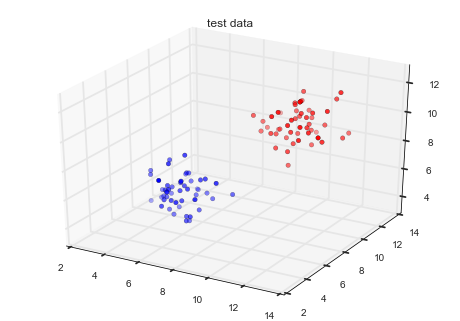

******************* K-means
mixture: [ 0.5  0.5]
mu [[  5.92168648   6.00042586   5.86691424]
 [ 10.27935454  10.21207876   9.88471757]]
Sigma: [[ 46.12307462  -8.74191667   3.34517806]
 [ -8.74191667  45.15409447  -7.48072604]
 [  3.34517806  -7.48072604  49.68106486]]
Sigma: [[ 55.95336916  -0.63653443   7.65032885]
 [ -0.63653443  50.16360724   5.18890337]
 [  7.65032885   5.18890337  45.56551815]]
******************* MLE
mixture: [ 0.49999898  0.50000102]
mu [[  5.92168214   6.00042366   5.86691412]
 [ 10.27935003  10.2120724    9.88470953]]
Sigma: [[ 0.92245377 -0.17484352  0.06690379]
 [-0.17484352  0.90308079 -0.14961433]
 [ 0.06690379 -0.14961433  0.9936225 ]]
Sigma: [[ 1.11907542 -0.01271641  0.15302376]
 [-0.01271641  1.00329059  0.10380241]
 [ 0.15302376  0.10380241  0.91134115]]


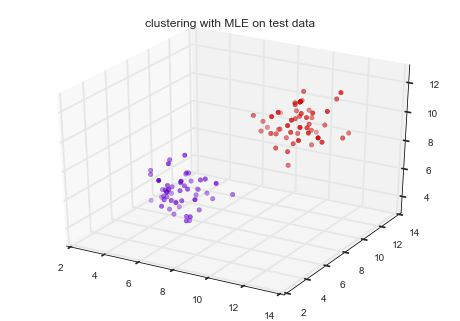

******************* MAP
mixture: [ 0.49816281  0.50183719]
mu [[  5.88727241   5.96637959   5.83403583]
 [ 10.22022658  10.15264193   9.82683254]]
Sigma: [[ 0.96145564  0.01773731  0.22000006]
 [ 0.01773731  0.95146156  0.03888805]
 [ 0.22000006  0.03888805  1.02108348]]
Sigma: [[ 1.4661053   0.48853655  0.61333719]
 [ 0.48853655  1.36478123  0.57054913]
 [ 0.61333719  0.57054913  1.2577051 ]]


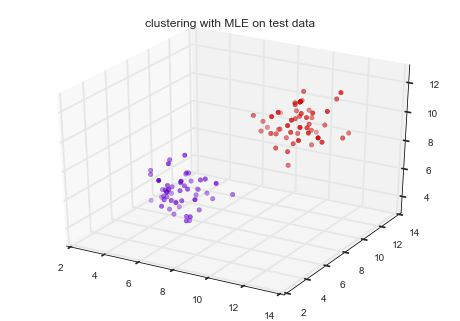

[array([[ 5.93175839,  7.71334272,  5.25524518],
        [ 5.17356146,  5.90154748,  5.33652171],
        [ 7.12663592,  4.92006849,  4.85253135],
        [ 5.56217996,  5.50196755,  7.92953205],
        [ 6.94942081,  6.08755124,  4.77456448],
        [ 6.84436298,  4.99978465,  4.4552289 ],
        [ 7.18802979,  6.31694261,  6.92085882],
        [ 6.31872765,  6.85683061,  5.34897441],
        [ 4.96575716,  6.68159452,  5.19659034],
        [ 5.31045022,  5.5444675 ,  6.01747916],
        [ 5.64600609,  4.62504871,  5.3563816 ],
        [ 3.77659685,  6.62523145,  4.39794234],
        [ 4.89561666,  6.05216508,  5.260437  ],
        [ 7.5430146 ,  4.70714309,  6.26705087],
        [ 5.96071718,  4.8319065 ,  6.52327666],
        [ 5.82845367,  6.77179055,  6.82350415],
        [ 8.16323595,  7.33652795,  5.63081816],
        [ 5.76062082,  7.0996596 ,  6.65526373],
        [ 6.64013153,  4.38304396,  5.97567388],
        [ 5.26196909,  6.2799246 ,  5.90184961],
        [ 6.91017891

In [94]:
########################################
########################################
#####     Run on test data         #####
########################################
########################################

#-------------   run parameters
iters = 500

#-------------   test data parameters
K = 2 #number of components
N = 100 #number of observations
D = 3 #number of attributes per observation

data = test_data(N, D) #make test data

#---------------- K-means initialization for MLE ----------------#
N = data.shape[0] #number of observations
K = 2 #number of components
D = data.shape[1] #number of features per observation

pi, mu, Sigma = k_means(N, D, K, data)

print '******************* K-means'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]


#---------------- MLE ----------------#
pi, mu, Sigma, r = MLE_EM(K, D, N, data, pi, mu, Sigma, iters)

print '******************* MLE'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]

#plot the components
plot_clusters(data, r, K, 'clustering with MLE on test data')


#---------------- MAP ----------------#

#random initialization of hyperparameters
alpha_0 = np.random.random(K)
beta_0 = np.random.random()
m_0 = np.zeros(D)
S_0 = np.eye(D)
nu_0 = D + 1

pi, X_mean, mu, S, Sigma, r = MAP_EM(K, D, N, data, pi, mu, Sigma, S_0, m_0, nu_0, beta_0, alpha_0, iters)

print '******************* MAP'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]

#plot the components
plot_clusters(data, r, K, 'clustering with MLE on test data')

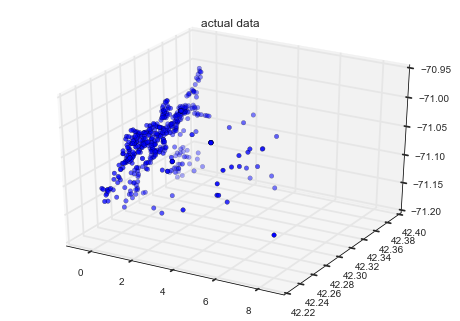

******************* K-means
mixture: [ 0.05090909  0.89454545  0.05454545]
mu [[  0.81763031  42.3218     -71.09086429]
 [ -0.28259876  42.32452398 -71.08365041]
 [  3.87149798  42.31321667 -71.08774333]]
Sigma: [[ 3.65009352 -0.11568874 -0.14587957]
 [-0.11568874  0.0312437   0.0075988 ]
 [-0.14587957  0.0075988   0.03668944]]
Sigma: [[ 4.42492183  0.01452876 -0.0302265 ]
 [ 0.01452876  0.50789028  0.17560249]
 [-0.0302265   0.17560249  0.56394501]]


In [106]:
########################################
########################################
#####     Run on real data         #####
########################################
########################################

data = real_data('March 15, 2014 12:00PM', 'March 19, 2014 12:00PM', 'Constituent Call')
data_std = data
data_std[:,0] = scale(data[:,0])
# print data_std[:,0]
# data_std[:,1:] = data[:,1:] 
#data_norm = normalize(data)
# print data_std

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_std[:, 0], data_std[:, 1], data_std[:, 2], c='b')

plt.title('actual data')
plt.show()

#---------------- K-means initialization for MLE ----------------#
N = data.shape[0] #number of observations
K = 3 #number of components
# D = data.shape[1] #number of features per observation
D = 3
pi, mu, Sigma = k_means(N, D, K, data_std[:,:3])

print '******************* K-means'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]


******************* MLE
mixture: [ 0.13541012  0.43321681  0.43137307]
mu [[  1.87491787  42.3202124  -71.08695477]
 [ -0.33875335  42.32652339 -71.07370462]
 [ -0.2483447   42.32211822 -71.09397033]]
Sigma: [[  3.28740477e+00  -1.74952515e-02  -1.14466659e-02]
 [ -1.74952515e-02   1.08757331e-03   2.14472300e-04]
 [ -1.14466659e-02   2.14472300e-04   1.10001574e-03]]
Sigma: [[  1.63627900e-04  -5.27584412e-06   6.81266082e-06]
 [ -5.27584412e-06   1.04239951e-03   5.10715720e-04]
 [  6.81266082e-06   5.10715720e-04   5.91152025e-04]]


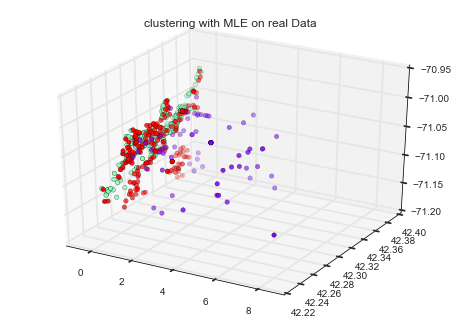

In [111]:
#---------------- Data parameters ----------------#
N = data.shape[0] #number of observations
K = 3 #number of components
D = data.shape[1] #number of features per observation
iters = 500

#---------------- MLE ----------------#

#initialization of parameters
pi = np.array([1./K] * K)
#mu_ind = np.random.randint(len(data_std), size=K)
# mu_ind = [372,  34]
mu_ind = [240, 367, 198] #k=3

mu = np.asarray([data_std[mu_ind[k]] for k in xrange(K)])

Sigma = [100. * np.eye(D) for k in xrange(K)] 

#run EM for MLE estimate
pi, mu, Sigma, r = MLE_EM(K, D, N, data_std, pi, mu, Sigma, iters)

print '******************* MLE'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]

#plot the components
clusters  = plot_clusters(data_std, r, K, 'clustering with MLE on real Data')

In [114]:
# Save the results in a json file for the visualizations
def save_to_json(K,clusters, title):
    d3_data_pd = pd.DataFrame(columns=['latitude','longitude','cluster'],index=range(N))
    start = 0 

    for k in range(K):

        end = start + len(clusters[k])
        d3_data_pd.latitude[start:end] = clusters[k][:,1] #Save latitude and longitude
        d3_data_pd.longitude[start:end] = clusters[k][:,2] 
        d3_data_pd.cluster[start:end] = k #Save cluster
        start += len(clusters[k])

    d3_data_pd.to_json(title +".json", orient="records")
    d3_data_pd.head()

In [117]:
save_to_json(3,clusters, "d3_boston311_3K")

[ 0.40087956  0.76819466  0.52771473]
0.237523137986
[267 337 299]
******************* MAP
mixture: [  1.21384691e-01   8.79476049e-01  -8.60740001e-04]
mu [[  2.07708715  42.16986022 -70.83771013]
 [ -0.28999726  42.30363302 -71.04875226]
 [  0.           0.           0.        ]]
Sigma: [[  2.84196429   0.25934515  -0.46932291]
 [  0.25934515   5.57663642  -9.34386935]
 [ -0.46932291  -9.34386935  15.71043821]]
Sigma: [[ 0.0078422  -0.00593325  0.00987987]
 [-0.00593325  0.867793   -1.45197937]
 [ 0.00987987 -1.45197937  2.44235291]]
clusters [array([[  2.64943578e+00,   4.23781000e+01,  -7.10581000e+01],
       [  1.03688208e+00,   4.23405000e+01,  -7.10737000e+01],
       [  5.05901000e-02,   4.23515000e+01,  -7.10863000e+01],
       [  1.02340201e+00,   4.23351000e+01,  -7.10756000e+01],
       [  4.44340878e+00,   4.23359000e+01,  -7.10766000e+01],
       [  4.39566686e+00,   4.23586000e+01,  -7.10709000e+01],
       [  1.02340201e+00,   4.23350000e+01,  -7.10755000e+01],
       

IndexError: too many indices for array

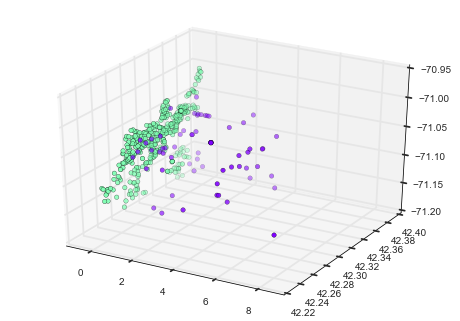

In [104]:
#---------------- Data parameters ----------------#
N = data.shape[0] #number of observations
K = 3 #number of components
D = data.shape[1] #number of features per observation

#---------------- MAP ----------------#

#random initialization of hyperparameters
alpha_0 = np.random.random(K)
print alpha_0
#alpha_0 = np.array([ 0.7480228,   0.79356737]) #k=2
#alpha_0 = np.array([ 0.4733262,   0.67512591,  0.02135868]) #k=3
beta_0 = np.random.random()
print beta_0
#beta_0 = 0.300651158697 #k=2
#beta_0 = 0.102316815888 #k=3
m_0 = np.zeros(D)
S_0 = np.eye(D)
nu_0 = D + 1

#initialization of parameters
pi = np.array([1./K] * K)
mu_ind = np.random.randint(len(data_std), size=K)
#mu_ind = [372,  34] #k=2
#mu_ind = [240, 367, 198] #k=3
print mu_ind
mu = np.asarray([data_std[mu_ind[k]] for k in xrange(K)])

Sigma = [100. * np.eye(D) for k in xrange(K)] 

#run EM for MAP estimate
pi, X_mean, mu, S, Sigma, r = MAP_EM(K, D, N, data_std, pi, mu, Sigma, S_0, m_0, nu_0, beta_0, alpha_0, iters)

print '******************* MAP'
print 'mixture:', pi
print 'mu', mu
print 'Sigma:', Sigma[0]
print 'Sigma:', Sigma[1]
    
#plot the components

plot_clusters(data_std, r, K, 'clustering with MAP on real Data')

In [112]:
K

3